In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy_indexed as npi

# Zadanie 0

### 1. Load IRIS dataset

In [766]:
# Load Iris
iris_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
iris_df = pd.read_csv(
    iris_url, header=None, 
    names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'target'])

### 2. Kmeans and other functions

In [85]:

def calc_dists(A,B):
    return np.square(np.sum(np.square(A)[:,np.newaxis,:], axis=2) - 2 * A.dot(B.T) + np.sum(np.square(B), axis=1))

def calc_dists2(A,B):
    return np.sqrt((np.square(A[:,np.newaxis]-B).sum(axis=2)))

def plot(data_df, centroids_df, x_name, y_name):  
    for index, centroid in centroids_df.iterrows():
        plt.scatter(centroid[x_name], centroid[y_name], marker='x', color='black')
    for id_centroid in data_df['closest_centroid'].unique().tolist():
        group = data_df[data_df['closest_centroid'] == id_centroid]
        plt.scatter(group[x_name], group[y_name], marker='.' )
        plt.title('K: ' + str(len(centroids_df)))
    plt.show()

    
def funn(data):
    return (data - np.mean(data))**2
    
def W(data):
    a = (data - data.mean()).values
    return np.sum(np.diag(np.dot(a,a.T)))

def BIC(data):
    return -2 * wdc(data) + data['closest_centroid'].nunique() * np.log(len(data))

def B(data, mean):
    a = data.mean().values - mean
    return len(data) * np.dot(a,a.T)


def kmeans(data_df, K, measure_fun):

    centroids = data_df.sample(K)
    data_df['closest_centroid'] = -1

    while(True):
        dists = calc_dists(data_df.copy().drop('closest_centroid',axis=1).values,centroids.values)
        if np.sum(data_df['closest_centroid'].values - dists.argmin(axis=1)) != 0:
            data_df['closest_centroid'] = dists.argmin(axis=1)
        else:
            break
        centroids = data_df.groupby(['closest_centroid']).mean()

    measure = -1
    if measure_fun == 'W':
        measure=np.sum(np.sum(data_df.groupby(['closest_centroid']).apply(W)))
    elif measure_fun == 'B':
        global_mean = data_df.mean().values
        measure=np.sum(np.sum(data_df.groupby(['closest_centroid']).apply(B,global_mean)))
    elif measure_fun == 'BIC':
        measure=np.sum(np.sum(data_df.groupby(['closest_centroid']).apply(BIC)))
   
    return data_df, measure, centroids


def k_means(data, K):
    
    N = np.shape(data)[0]
    
    #initialize centroids
    id_centroids = np.random.randint(0, N, size=K)
    centroids = data[id_centroids,:]
    
    # initialize closest centroids
    closest_centroids = np.zeros(N)
        
    for i in range(40):
        dists = calc_dists2(data, centroids)
        closest_centroids = np.argmin(dists,axis=1)
        centroids = npi.group_by(closest_centroids).mean(data)[1]

    measure = np.sum(np.min(calc_dists2(data, centroids), axis=1))
             
    return centroids, closest_centroids, measure
    


### 3. Plot few different measures

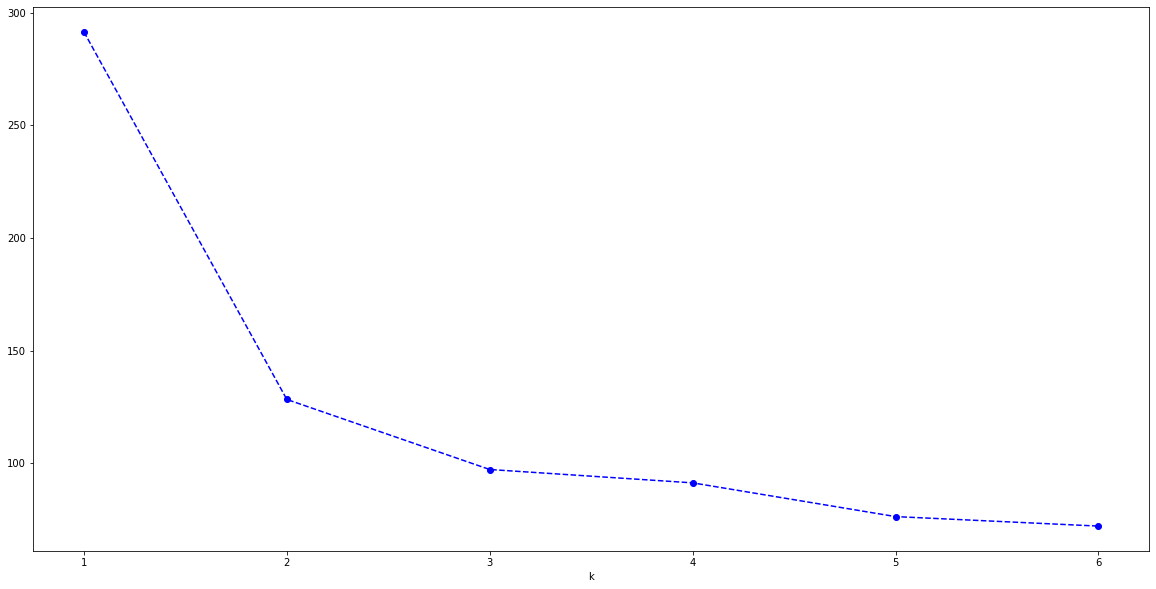

In [1454]:
data = iris_df.drop(['target'], axis=1).values

kk = []
w = []
n_k = 7
for k in range(1,n_k):
    w.append(k_means(data,k)[2])
    kk.append(k)

plt.xticks(np.arange(1,n_k))
plt.xlabel('k')
plt.plot(kk, w, 'bo', linestyle = 'dashed')
plt.show()


### 4. Plot grouped data

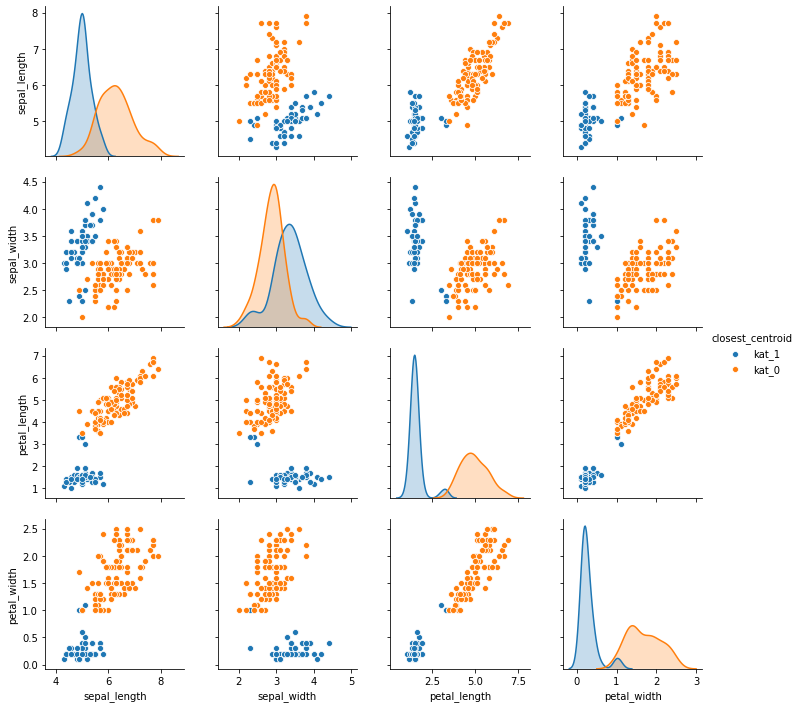

In [1473]:
data_df = iris_df.drop(['target'], axis=1)
data_df['closest_centroid'] = k_means(data_df.values,2)[1]
data_df['closest_centroid'] = "kat_" + data_df['closest_centroid'].astype(str)
sns.pairplot(data_df, hue='closest_centroid')

# Zadanie 1


### Functions

In [28]:
# zwraca amcierz Nxd z wylosowanymi wektorami z K chmur
def rand(N, d, K, p , cov_matrices):
    if np.shape(p)[0] != K or np.shape(cov_matrices)[0] != K or np.shape(cov_matrices)[1] != d or np.shape(cov_matrices)[2] != d : 
            print("Niezgodnosc wyniarów")
            return -1
        
    k = np.arange(1,K+1,1)
    mu = np.repeat([3*k],d).reshape(K,d)
    
    L_matrices = []
    for i in range(K):
        L_matrices.append(np.linalg.cholesky(cov_matrices[i,:,:]))
    
    data = []
    for i in range(N):
        ran = np.random.choice(np.arange(K), p=p)
        x = mu[ran,:] + np.dot(L_matrices[ran], np.random.normal(0,1, size=d) )
        data.append(x)
    data = np.vstack(data)
    return data

def plot_measures(data_df, n_k):
    kk = []
    w = []
    for k in range(1,n_k):
        w.append(k_means(data_df.values,k)[2])
        kk.append(k)
    plt.xticks(np.arange(1,n_k))
    plt.xlabel('k')
    plt.plot(kk, w, 'go', linestyle = 'dashed')
    plt.show()


    


### a)

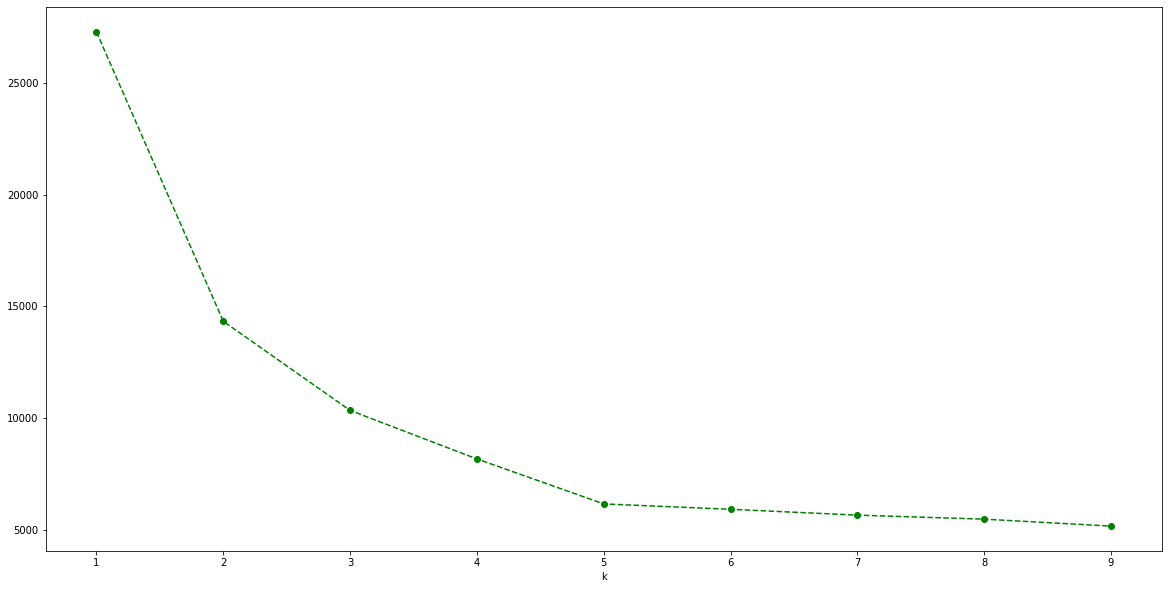

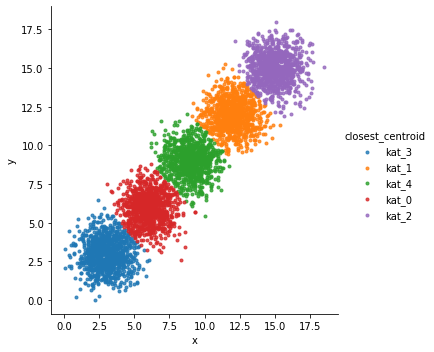

In [1488]:

N = 5000
d = 2
K = 5
p = np.repeat(1/K,K)

sigma1 = np.eye(d)
covariance_matrices = np.concatenate((sigma1,sigma1,sigma1,sigma1,sigma1)).reshape(K,d,d)

data_df = pd.DataFrame(data=rand(N,d,K,p,covariance_matrices), index=np.arange(1,N+1,1), columns=['x','y'])


plot_measures(data_df,10)
data_df['closest_centroid'] = k_means(data_df.values,5)[1]
data_df['closest_centroid'] = "kat_" + data_df['closest_centroid'].astype(str)
sns.lmplot('x', 'y', markers = '.', data=data_df, hue='closest_centroid', fit_reg=False)


### b)

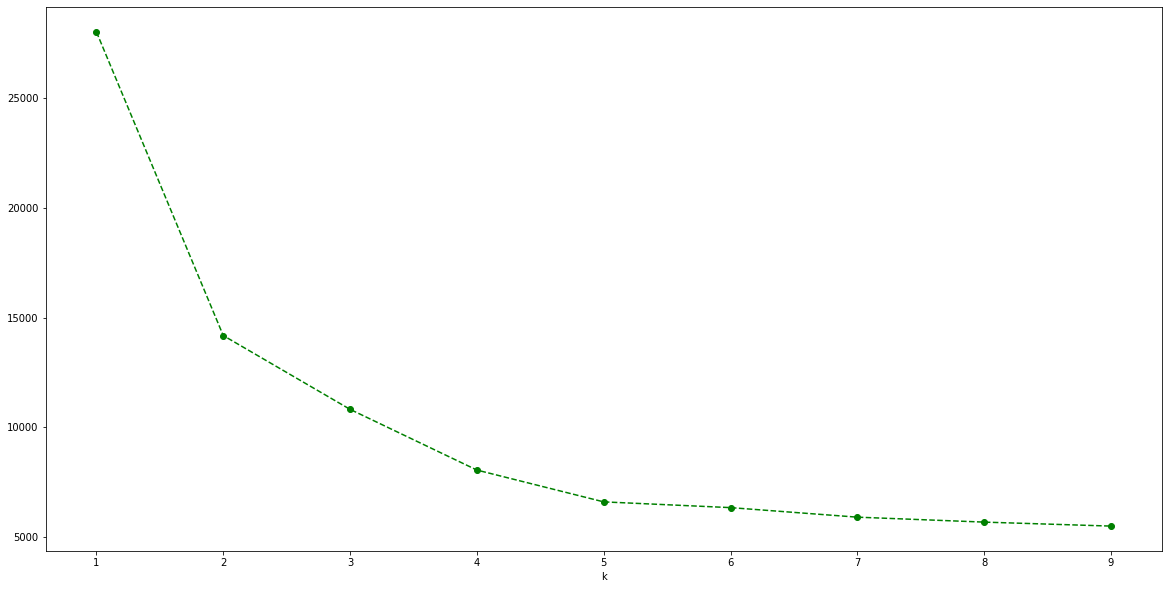

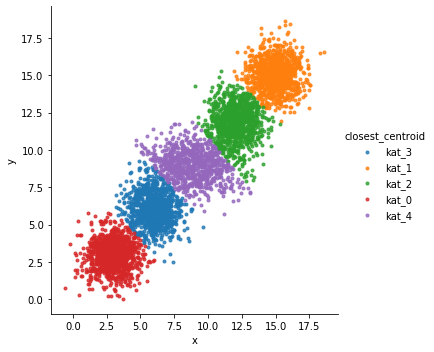

In [1489]:
N = 5000
d = 2
K = 5

p = np.repeat(1/K,K)
k = np.arange(1,K+1,1)
mu = np.repeat([3*k],d).reshape(K,d)


sigma1 = np.eye(d)
sigma3 = np.array([[3,0],[0,1]])

covariance_matrices = np.concatenate((sigma1,sigma1,sigma3,sigma1,sigma1)).reshape(K,d,d)

data_df = pd.DataFrame(data=rand(N,d,K,p,covariance_matrices), index=np.arange(1,N+1,1), columns=['x','y'])

plot_measures(data_df,10)
data_df['closest_centroid'] = k_means(data_df.values,5)[1]
data_df['closest_centroid'] = "kat_" + data_df['closest_centroid'].astype(str)
sns.lmplot('x', 'y', markers = '.', data=data_df, hue='closest_centroid', fit_reg=False)


### c)

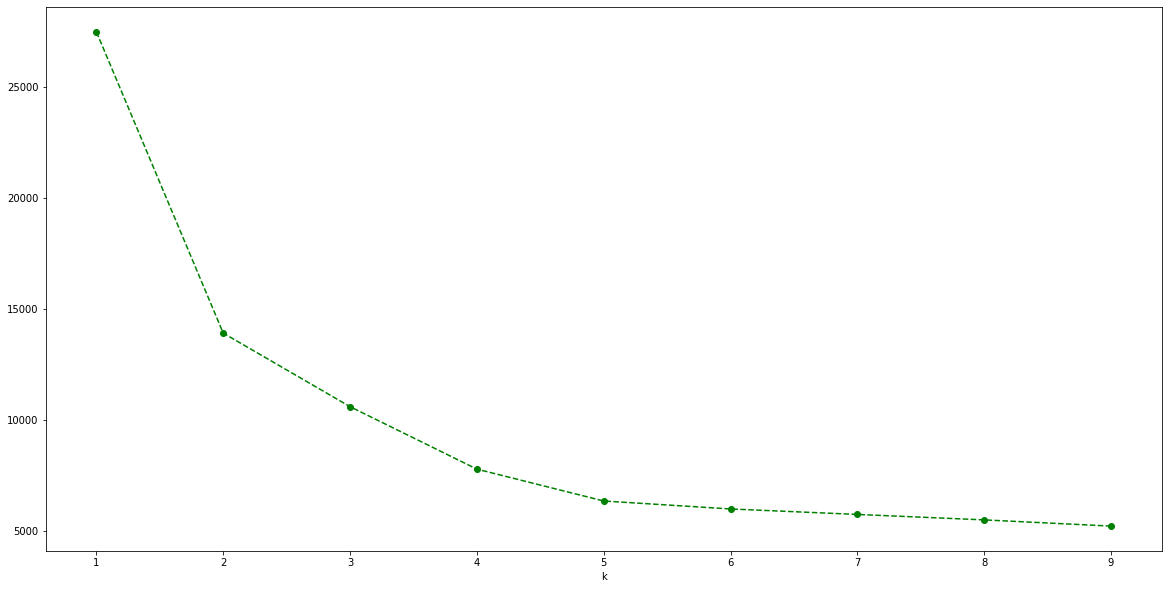

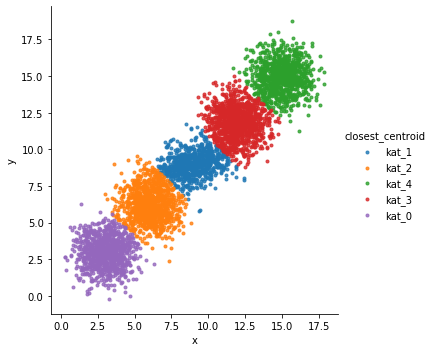

In [1490]:
N = 5000
d = 2
K = 5
p = np.repeat(1/K,K)

sigma1 = np.eye(d)
sigma3 = np.array([[3,1],[1,1]])

covariance_matrices = np.concatenate((sigma1,sigma1,sigma3,sigma1,sigma1)).reshape(K,d,d)
data_df = pd.DataFrame(data=rand(N,d,K,p,covariance_matrices), index=np.arange(1,N+1,1), columns=['x','y'])


plot_measures(data_df,10)
data_df['closest_centroid'] = k_means(data_df.values,5)[1]
data_df['closest_centroid'] = "kat_" + data_df['closest_centroid'].astype(str)
sns.lmplot('x', 'y', markers = '.', data=data_df, hue='closest_centroid', fit_reg=False)

### d)

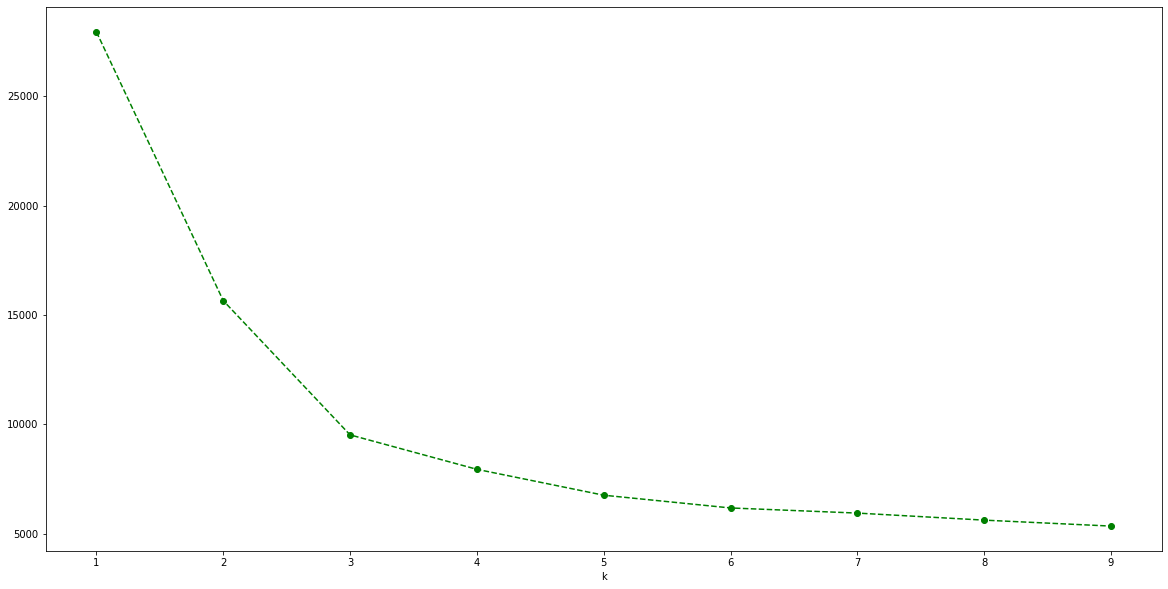

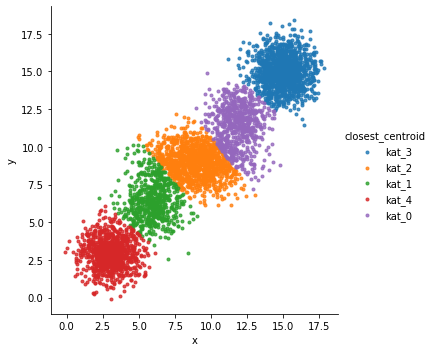

In [1491]:
N = 5000
d = 2
K = 5
p = np.array([.2,.1,.3,.1,.3])

sigma1 = np.eye(d)
sigma3 = np.array([[3,0],[0,1]])

covariance_matrices = np.concatenate((sigma1,sigma1,sigma3,sigma1,sigma1)).reshape(K,d,d)

data_df = pd.DataFrame(data=rand(N,d,K,p,covariance_matrices), index=np.arange(1,N+1,1), columns=['x','y'])

plot_measures(data_df,10)
data_df['closest_centroid'] = k_means(data_df.values,5)[1]
data_df['closest_centroid'] = "kat_" + data_df['closest_centroid'].astype(str)
sns.lmplot('x', 'y', markers = '.', data=data_df, hue='closest_centroid', fit_reg=False)


### e)

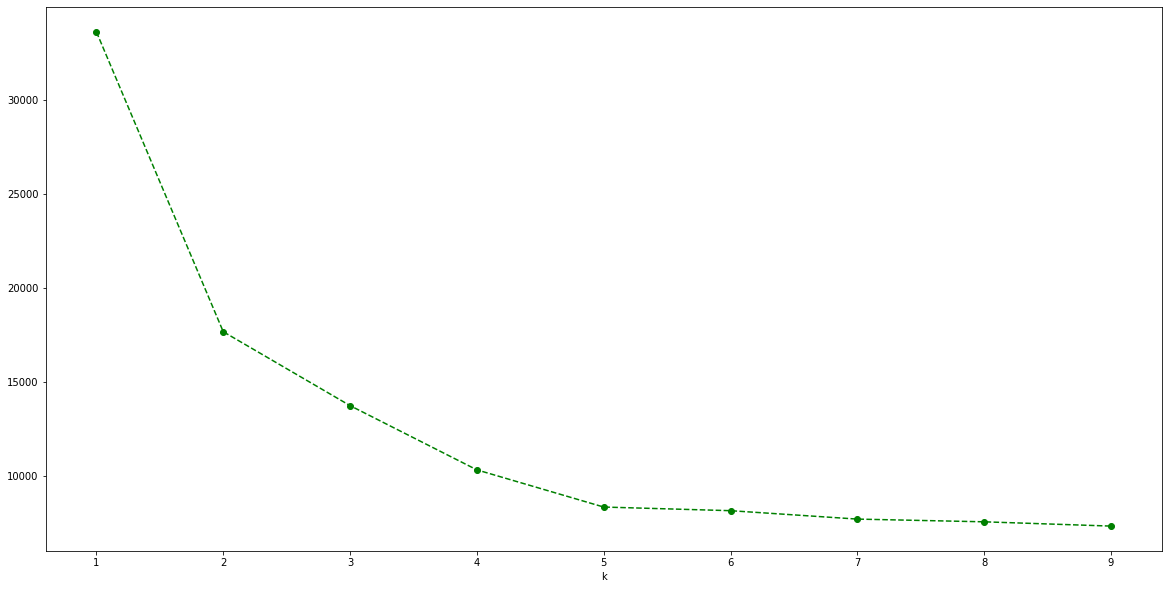

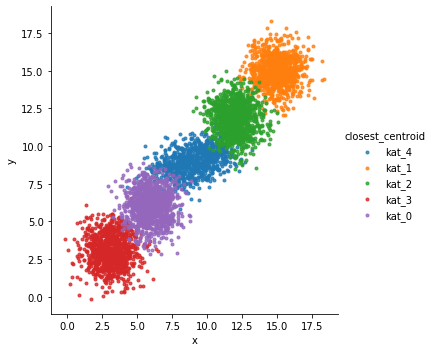

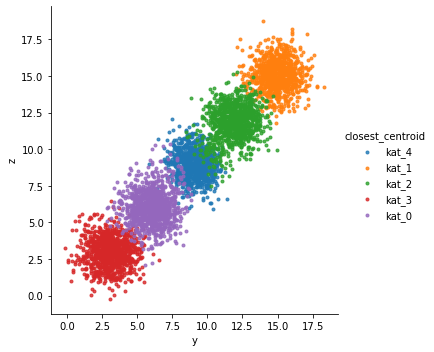

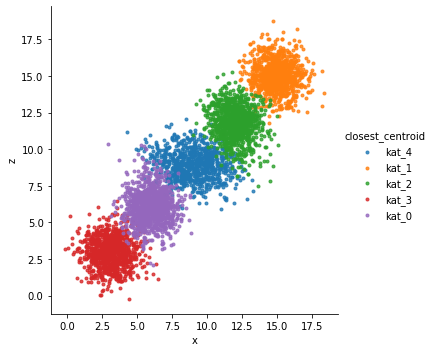

In [1492]:
N = 5000
d = 3
K = 5
p = np.repeat(1/K,K)

sigma1 = np.eye(d)
sigma3 = np.array([[3,1,0],[1,1,0],[0,0,1]])


covariance_matrices = np.concatenate((sigma1,sigma1,sigma3,sigma1,sigma1)).reshape(K,d,d)

data_df = pd.DataFrame(data=rand(N,d,K,p,covariance_matrices), index=np.arange(1,N+1,1), columns=['x','y','z'])


plot_measures(data_df,10)
data_df['closest_centroid'] = k_means(data_df.values,5)[1]
data_df['closest_centroid'] = "kat_" + data_df['closest_centroid'].astype(str)
sns.lmplot('x', 'y', markers = '.', data=data_df, hue='closest_centroid', fit_reg=False)
sns.lmplot('y', 'z', markers = '.', data=data_df, hue='closest_centroid', fit_reg=False)
sns.lmplot('x', 'z', markers = '.', data=data_df, hue='closest_centroid', fit_reg=False)

In [558]:
# from mpl_toolkits import mplot3d

# ax = plt.axes(projection='3d')


# # Data for three-dimensional scattered points
# zdata = data[:,0]
# xdata = data[:,1]
# ydata = data[:,2]
# ax.scatter3D(xdata, ydata, zdata);
# xdata

### f)

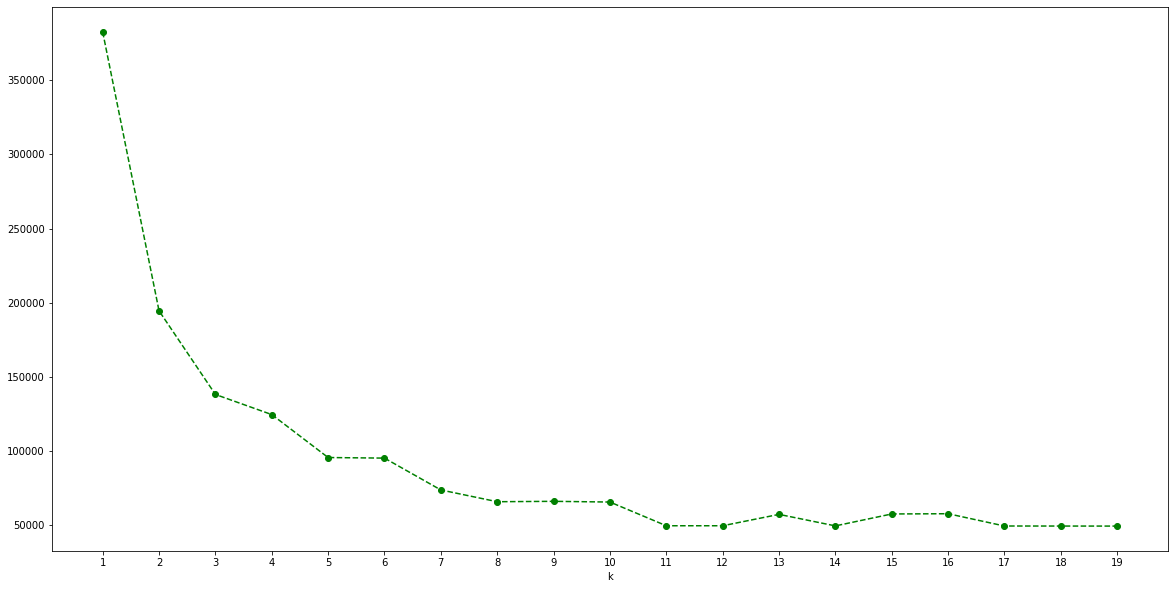

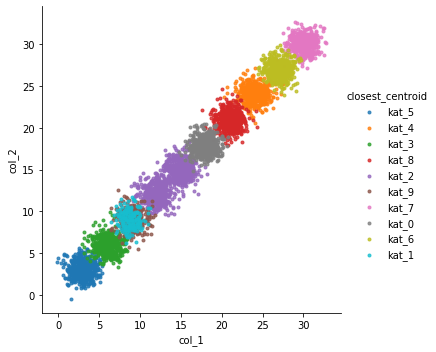

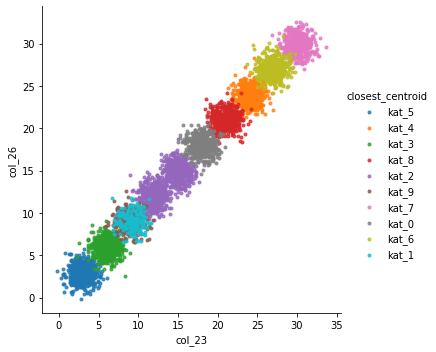

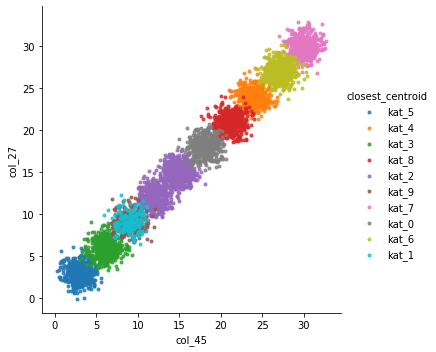

In [1545]:
N = 5000
d = 100
K = 10

p = np.repeat(1/K,K)
k = np.arange(1,K+1,1)
mu = np.repeat([3*k],d).reshape(K,d)

a = np.eye(d)
covariance_matrices = np.repeat(a[np.newaxis, :, :], K, axis=0)


col = np.arange(1,d+1,1)
col = col.astype(str)
b = np.repeat('col_',d)
np.core.defchararray.add(b,col)
data_df = pd.DataFrame(data=rand(N,d,K,p,covariance_matrices), index=np.arange(1,N+1,1), columns=np.core.defchararray.add(b,col))


#plot_measures(data_df,7)
#sns.lmplot('x', 'y', markers = '.', data=kmeans(data_df.copy(),5,'W')[0], hue='closest_centroid', fit_reg=False)


plot_measures(data_df,20)
data_df['closest_centroid'] = k_means(data_df.values,10)[1]
data_df['closest_centroid'] = "kat_" + data_df['closest_centroid'].astype(str)
sns.lmplot('col_1', 'col_2', markers = '.', data=data_df, hue='closest_centroid', fit_reg=False)
sns.lmplot('col_23', 'col_26', markers = '.', data=data_df, hue='closest_centroid', fit_reg=False)
sns.lmplot('col_45', 'col_27', markers = '.', data=data_df, hue='closest_centroid', fit_reg=False)



# Zadanie 2


In [1115]:
N = 10000
d = 1000
K = 1000
q=10

p = np.repeat(1/K,K)
k = np.arange(1,K+1,1)
mu = np.repeat([q*k],d).reshape(K,d)

Covariance = np.eye(d)
L = Covariance

u = np.random.normal(0,1, size=d*N).reshape(d, N)

idx = np.random.randint(K, size=N)

x = mu[idx,:] + np.dot(L, u).T

data_df = pd.DataFrame(data=x, index=np.arange(1,N+1,1), columns=list(map(str,np.arange(1,d+1,1))) )  # 1st row as the column names



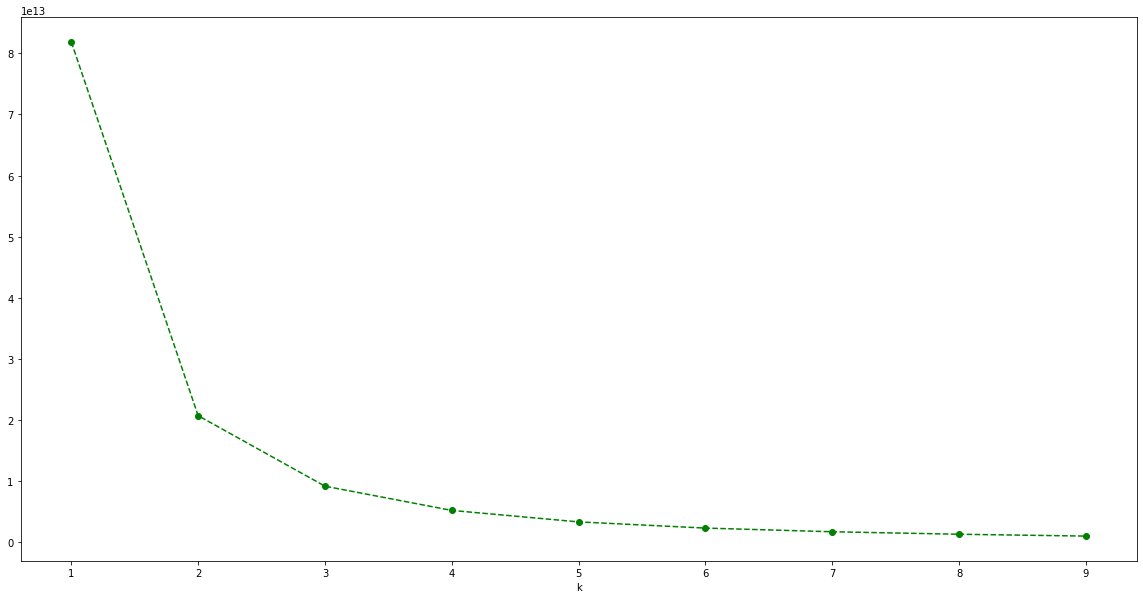

In [1117]:
plot_measures(data_df,10)



# Zadanie 3


In [75]:
#@title Data Loading
# We will load a few commonly used datasets:
# - iris
# - wine

# 1. Iris
iris_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
iris_df = pd.read_csv(
    iris_url, header=None, 
    names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'target'])

# 2. Wine
wine_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'
wine_df = pd.read_csv(
    wine_url, header=None, 
    names=['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanhoycanina', 'color_intensity', 'hue', 'diluted_wines', 'proline'])

# 3. Haberman
haberman_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/haberman/haberman.data'
haberman_df = pd.read_csv(
    haberman_url, header=None, 
    names=['age','year', 'axillary_nodes', 'target'])

haberman_df.head()
haberman_df['target'] = "cat_" + haberman_df['target'].astype(str)

# 3. Perfume
perfume_path = '/home/michal/Dokumenty/Studia/UWr/7/Eksploracja_Danych/lista3/datasets/perfume_data.csv'
perfume_df = pd.read_csv(
    perfume_path, header=0)

# 4. Data user modelling
user_path = '/home/michal/Dokumenty/Studia/UWr/7/Eksploracja_Danych/lista3/datasets/data_user_modelling.csv'
user_df = pd.read_csv(
    user_path, header=0)




## 3.1 Iris

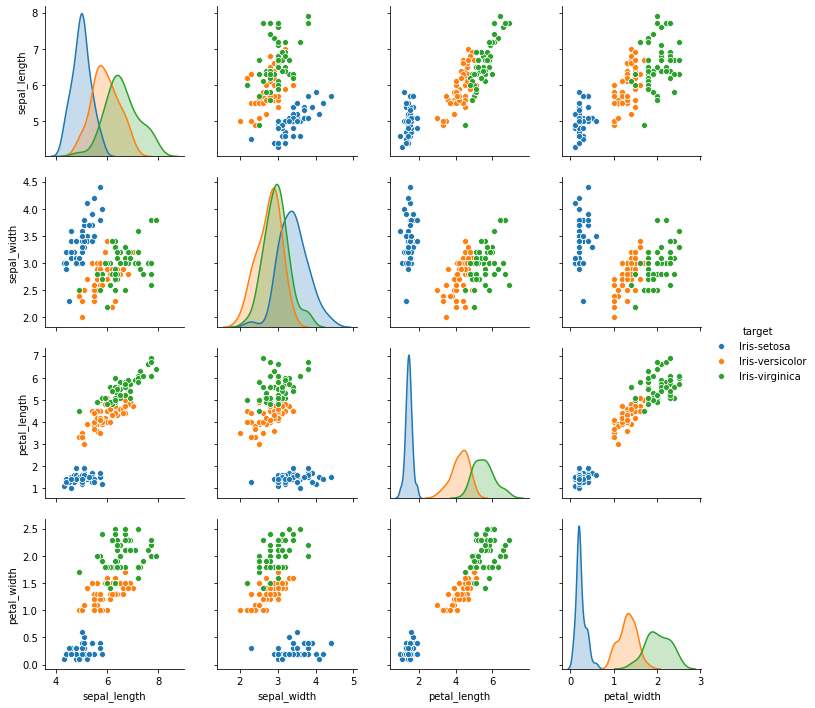

In [38]:
sns.pairplot(iris_df, hue='target')

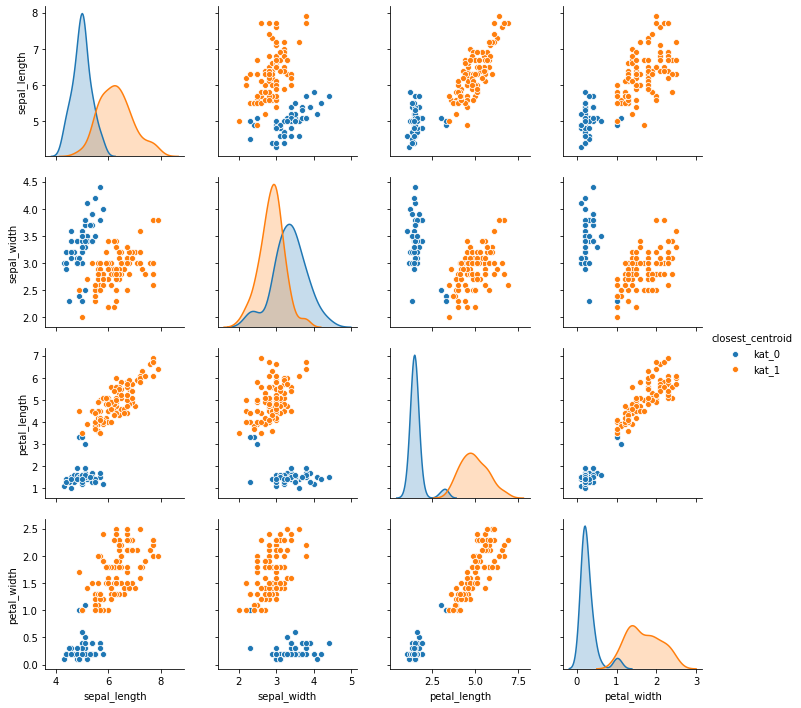

In [37]:
data_df = iris_df.drop(['target'], axis=1)
data_df['closest_centroid'] = k_means(data_df.values,2)[1]
data_df['closest_centroid'] = "kat_" + data_df['closest_centroid'].astype(str)
sns.pairplot(data_df, hue='closest_centroid')

## 3.2 Haberman

In [49]:
haberman_df.head()

age  year  axillary_nodes target
0   30    64               1  cat_1
1   30    62               3  cat_1
2   30    65               0  cat_1
3   31    59               2  cat_1
4   31    65               4  cat_1

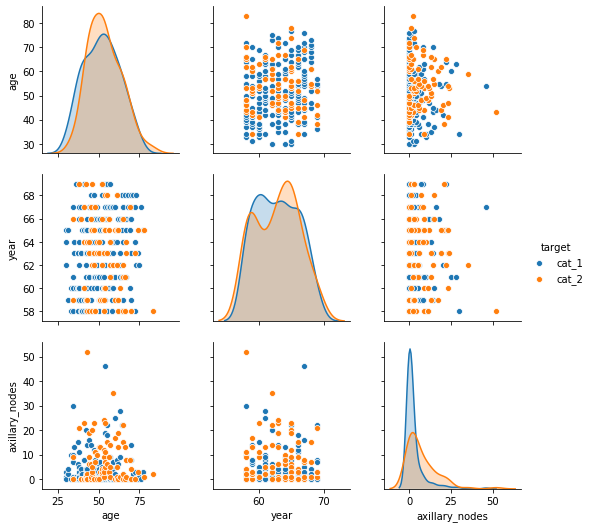

In [644]:
sns.pairplot(haberman_df, hue="target")

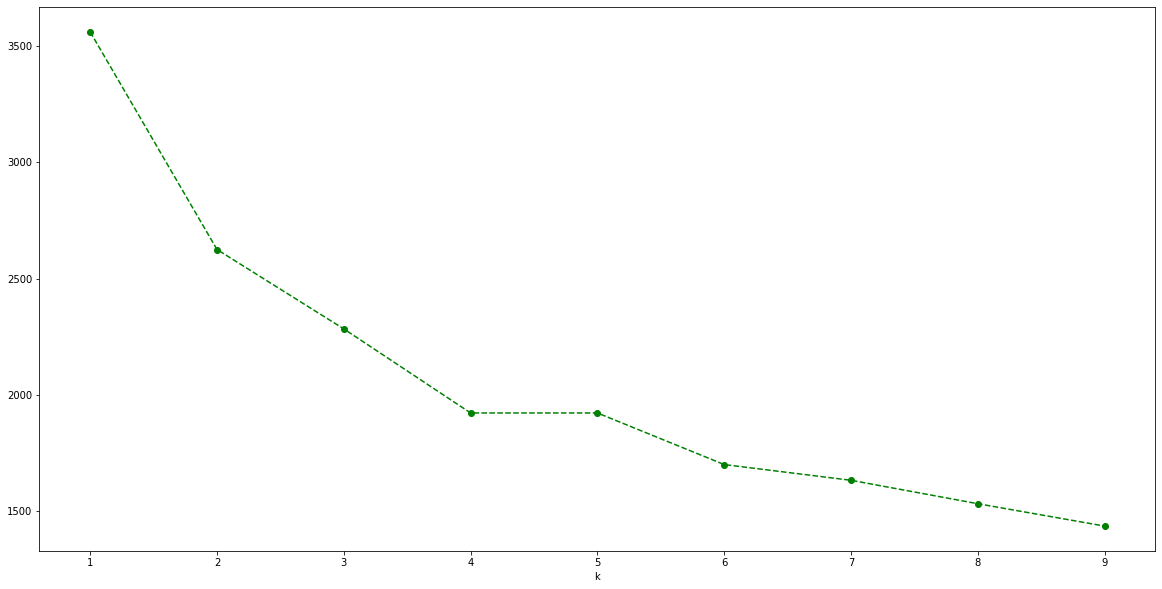

In [51]:
data_df = pd.read_csv(
    haberman_url, header=None, 
    names=['age','year', 'axillary_nodes', 'target'])

plot_measures(data_df.drop('target', axis=1),10)

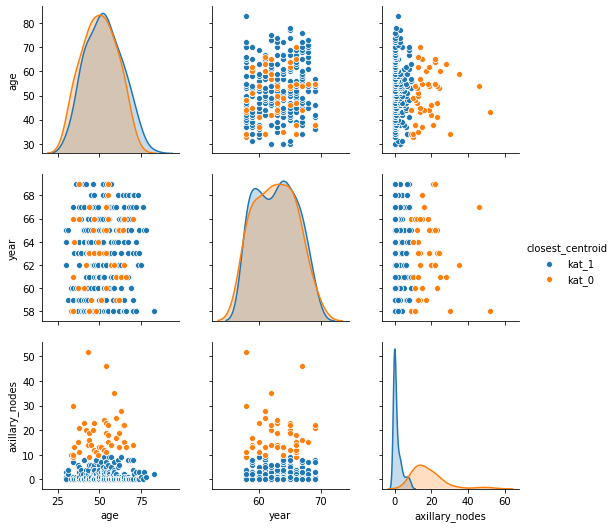

In [52]:
data_df = pd.read_csv(
    haberman_url, header=None, 
    names=['age','year', 'axillary_nodes', 'target'])
data_df['closest_centroid'] = k_means(data_df.drop('target', axis=1).values,2)[1]
data_df['closest_centroid'] = "kat_" + data_df['closest_centroid'].astype(str)

sns.pairplot(data_df.drop('target', axis=1), hue='closest_centroid')

## 3.3 User data

In [76]:
user_df.head()

STG   SCG   STR   LPR   PEG       UNS
0  0.00  0.00  0.00  0.00  0.00  very_low
1  0.08  0.08  0.10  0.24  0.90      High
2  0.06  0.06  0.05  0.25  0.33       Low
3  0.10  0.10  0.15  0.65  0.30    Middle
4  0.08  0.08  0.08  0.98  0.24       Low

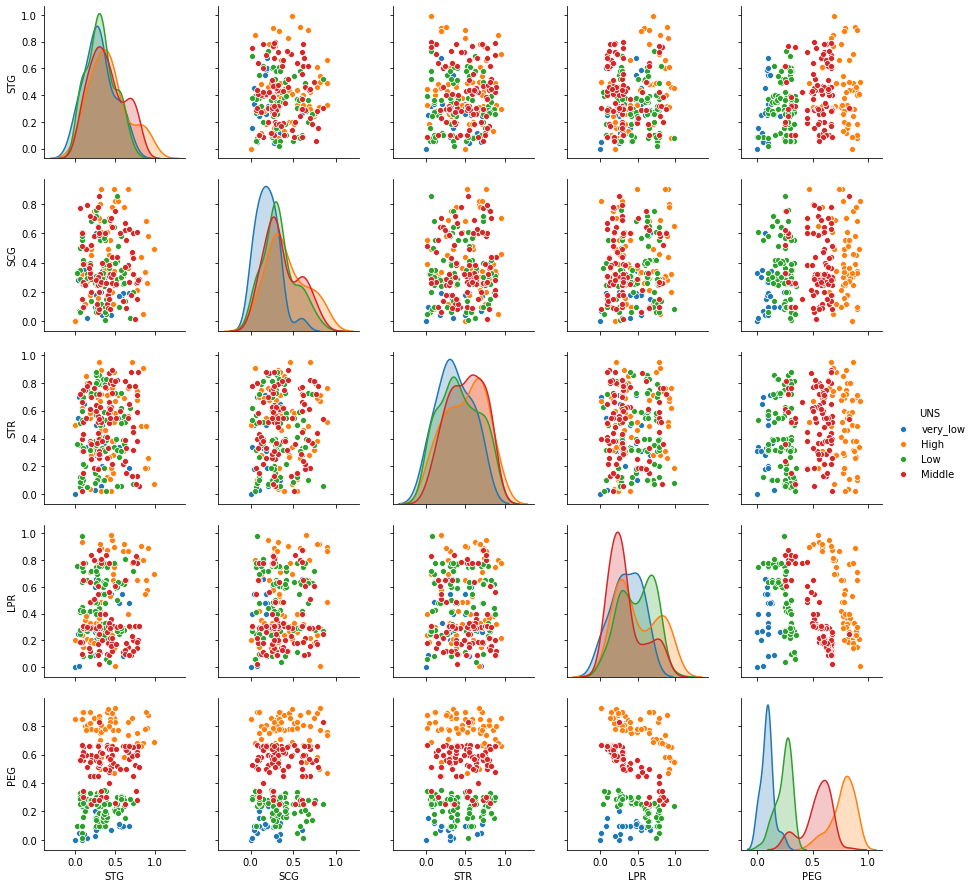

In [726]:
sns.pairplot(user_df, hue = 'UNS')

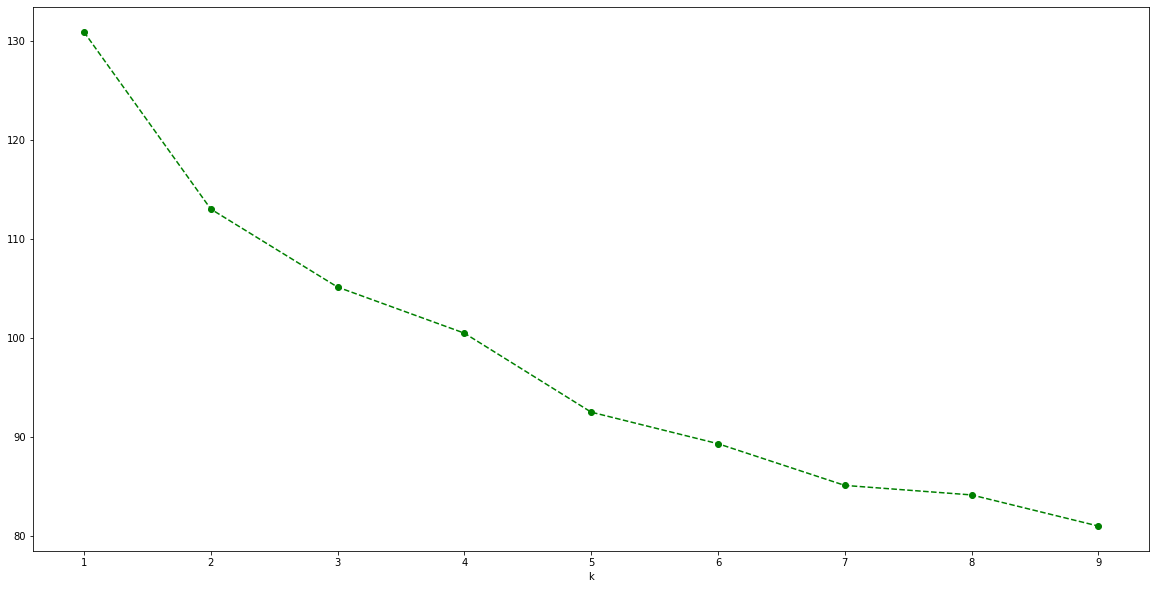

In [56]:
plot_measures(user_df.copy().drop('UNS',axis=1),10)

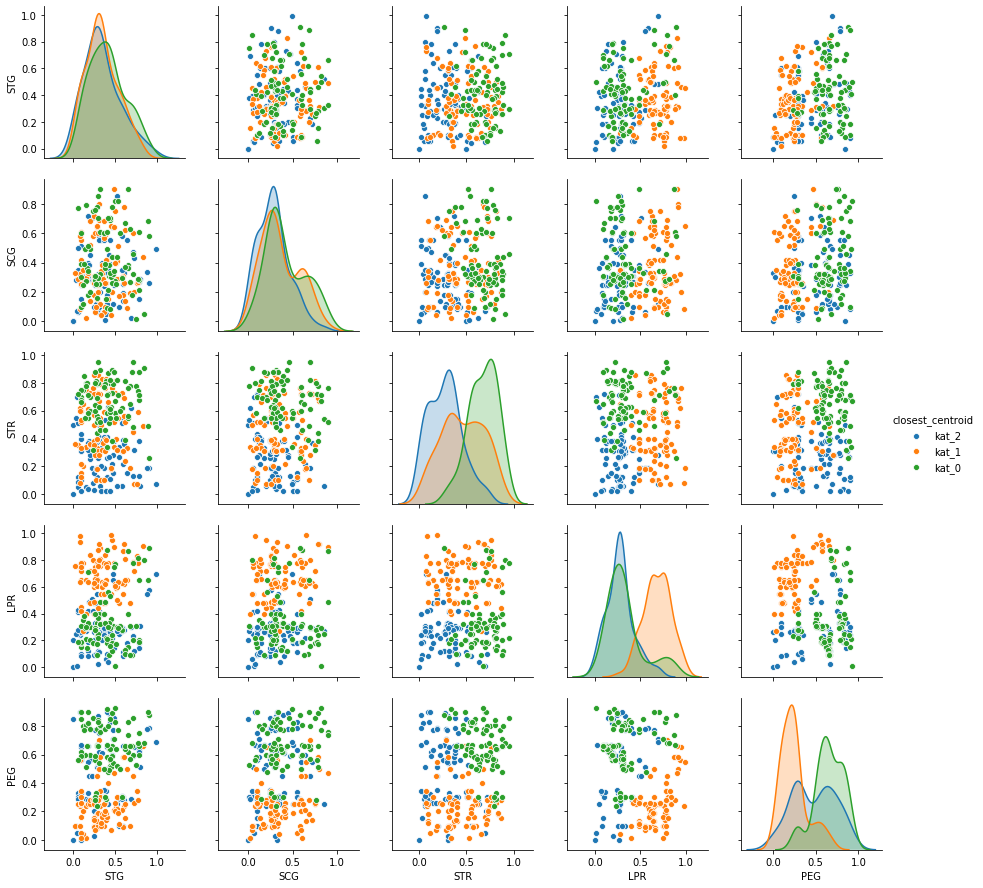

In [80]:
data_df = user_df.copy()
data_df['closest_centroid'] = k_means(data_df.drop('UNS', axis=1).values,3)[1]
data_df['closest_centroid'] = "kat_" + data_df['closest_centroid'].astype(str)

sns.pairplot(data_df.drop('UNS', axis=1), hue='closest_centroid')

## 3.4 Wine

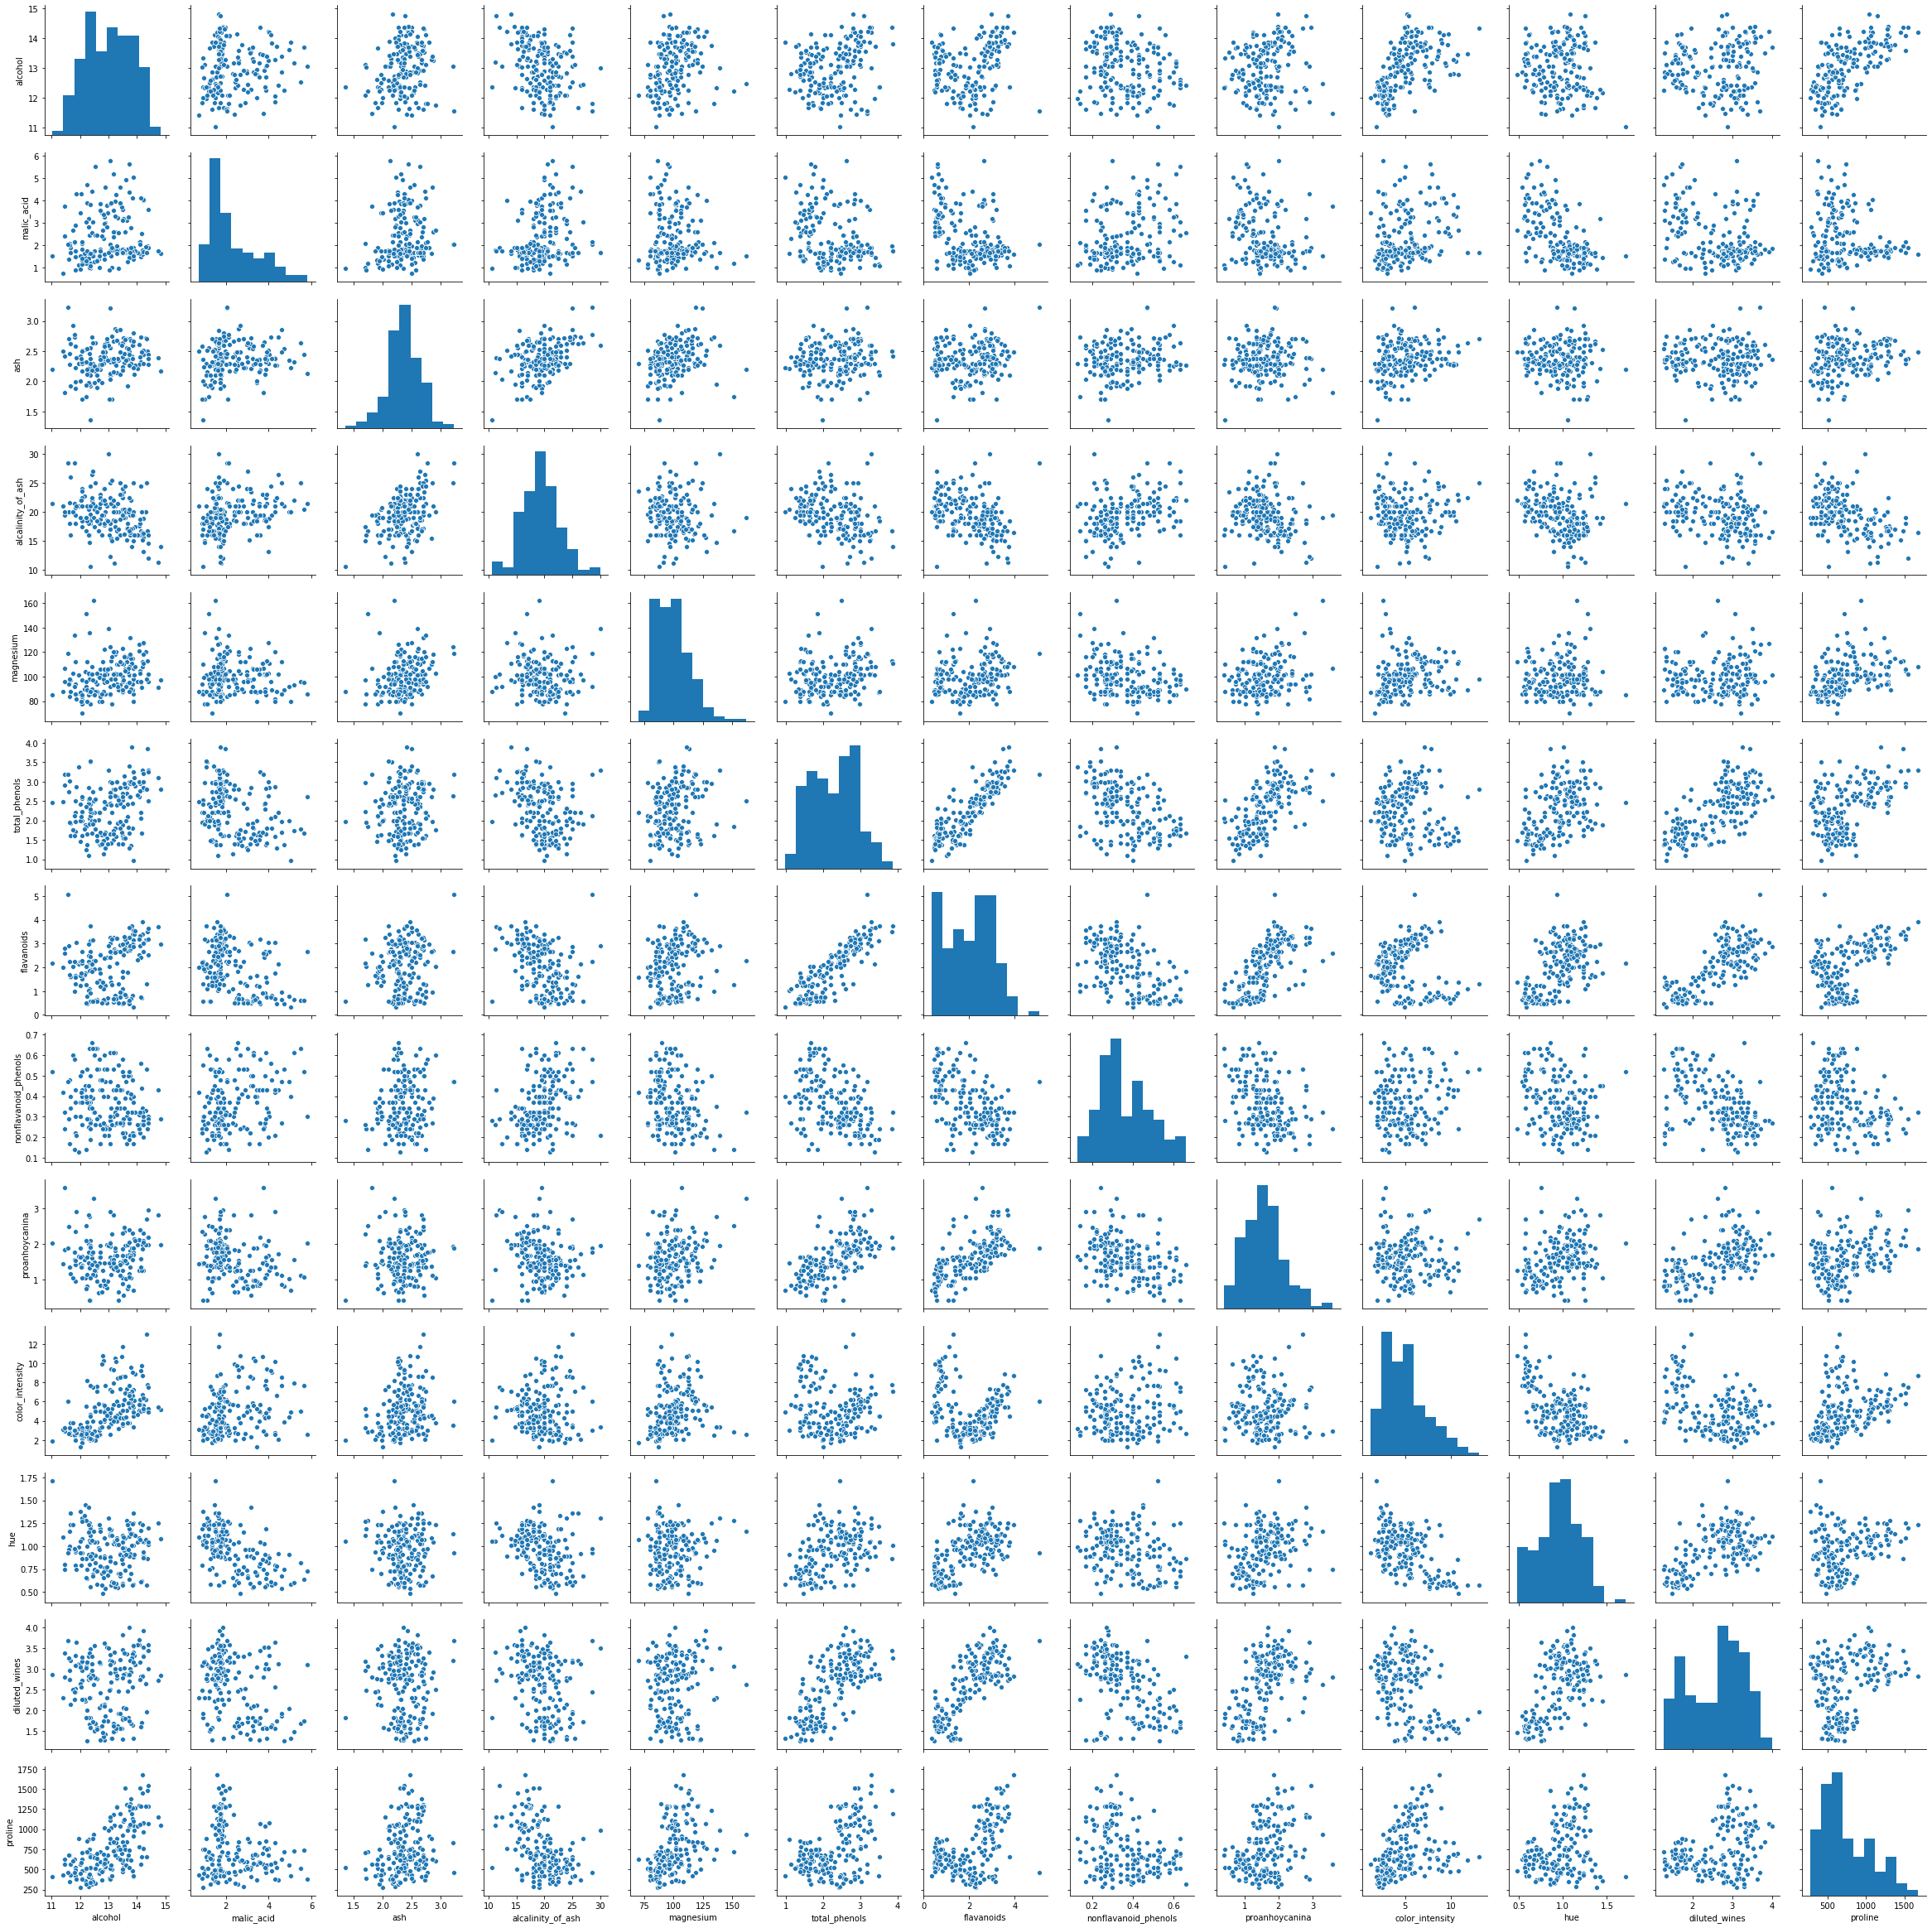

In [81]:
sns.pairplot(wine_df)

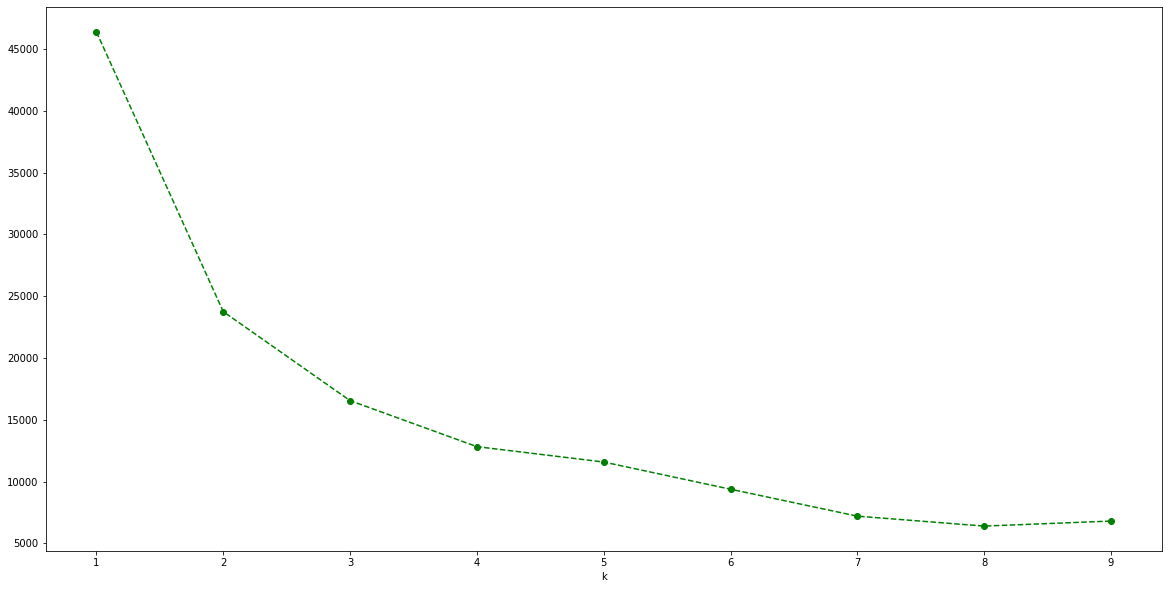

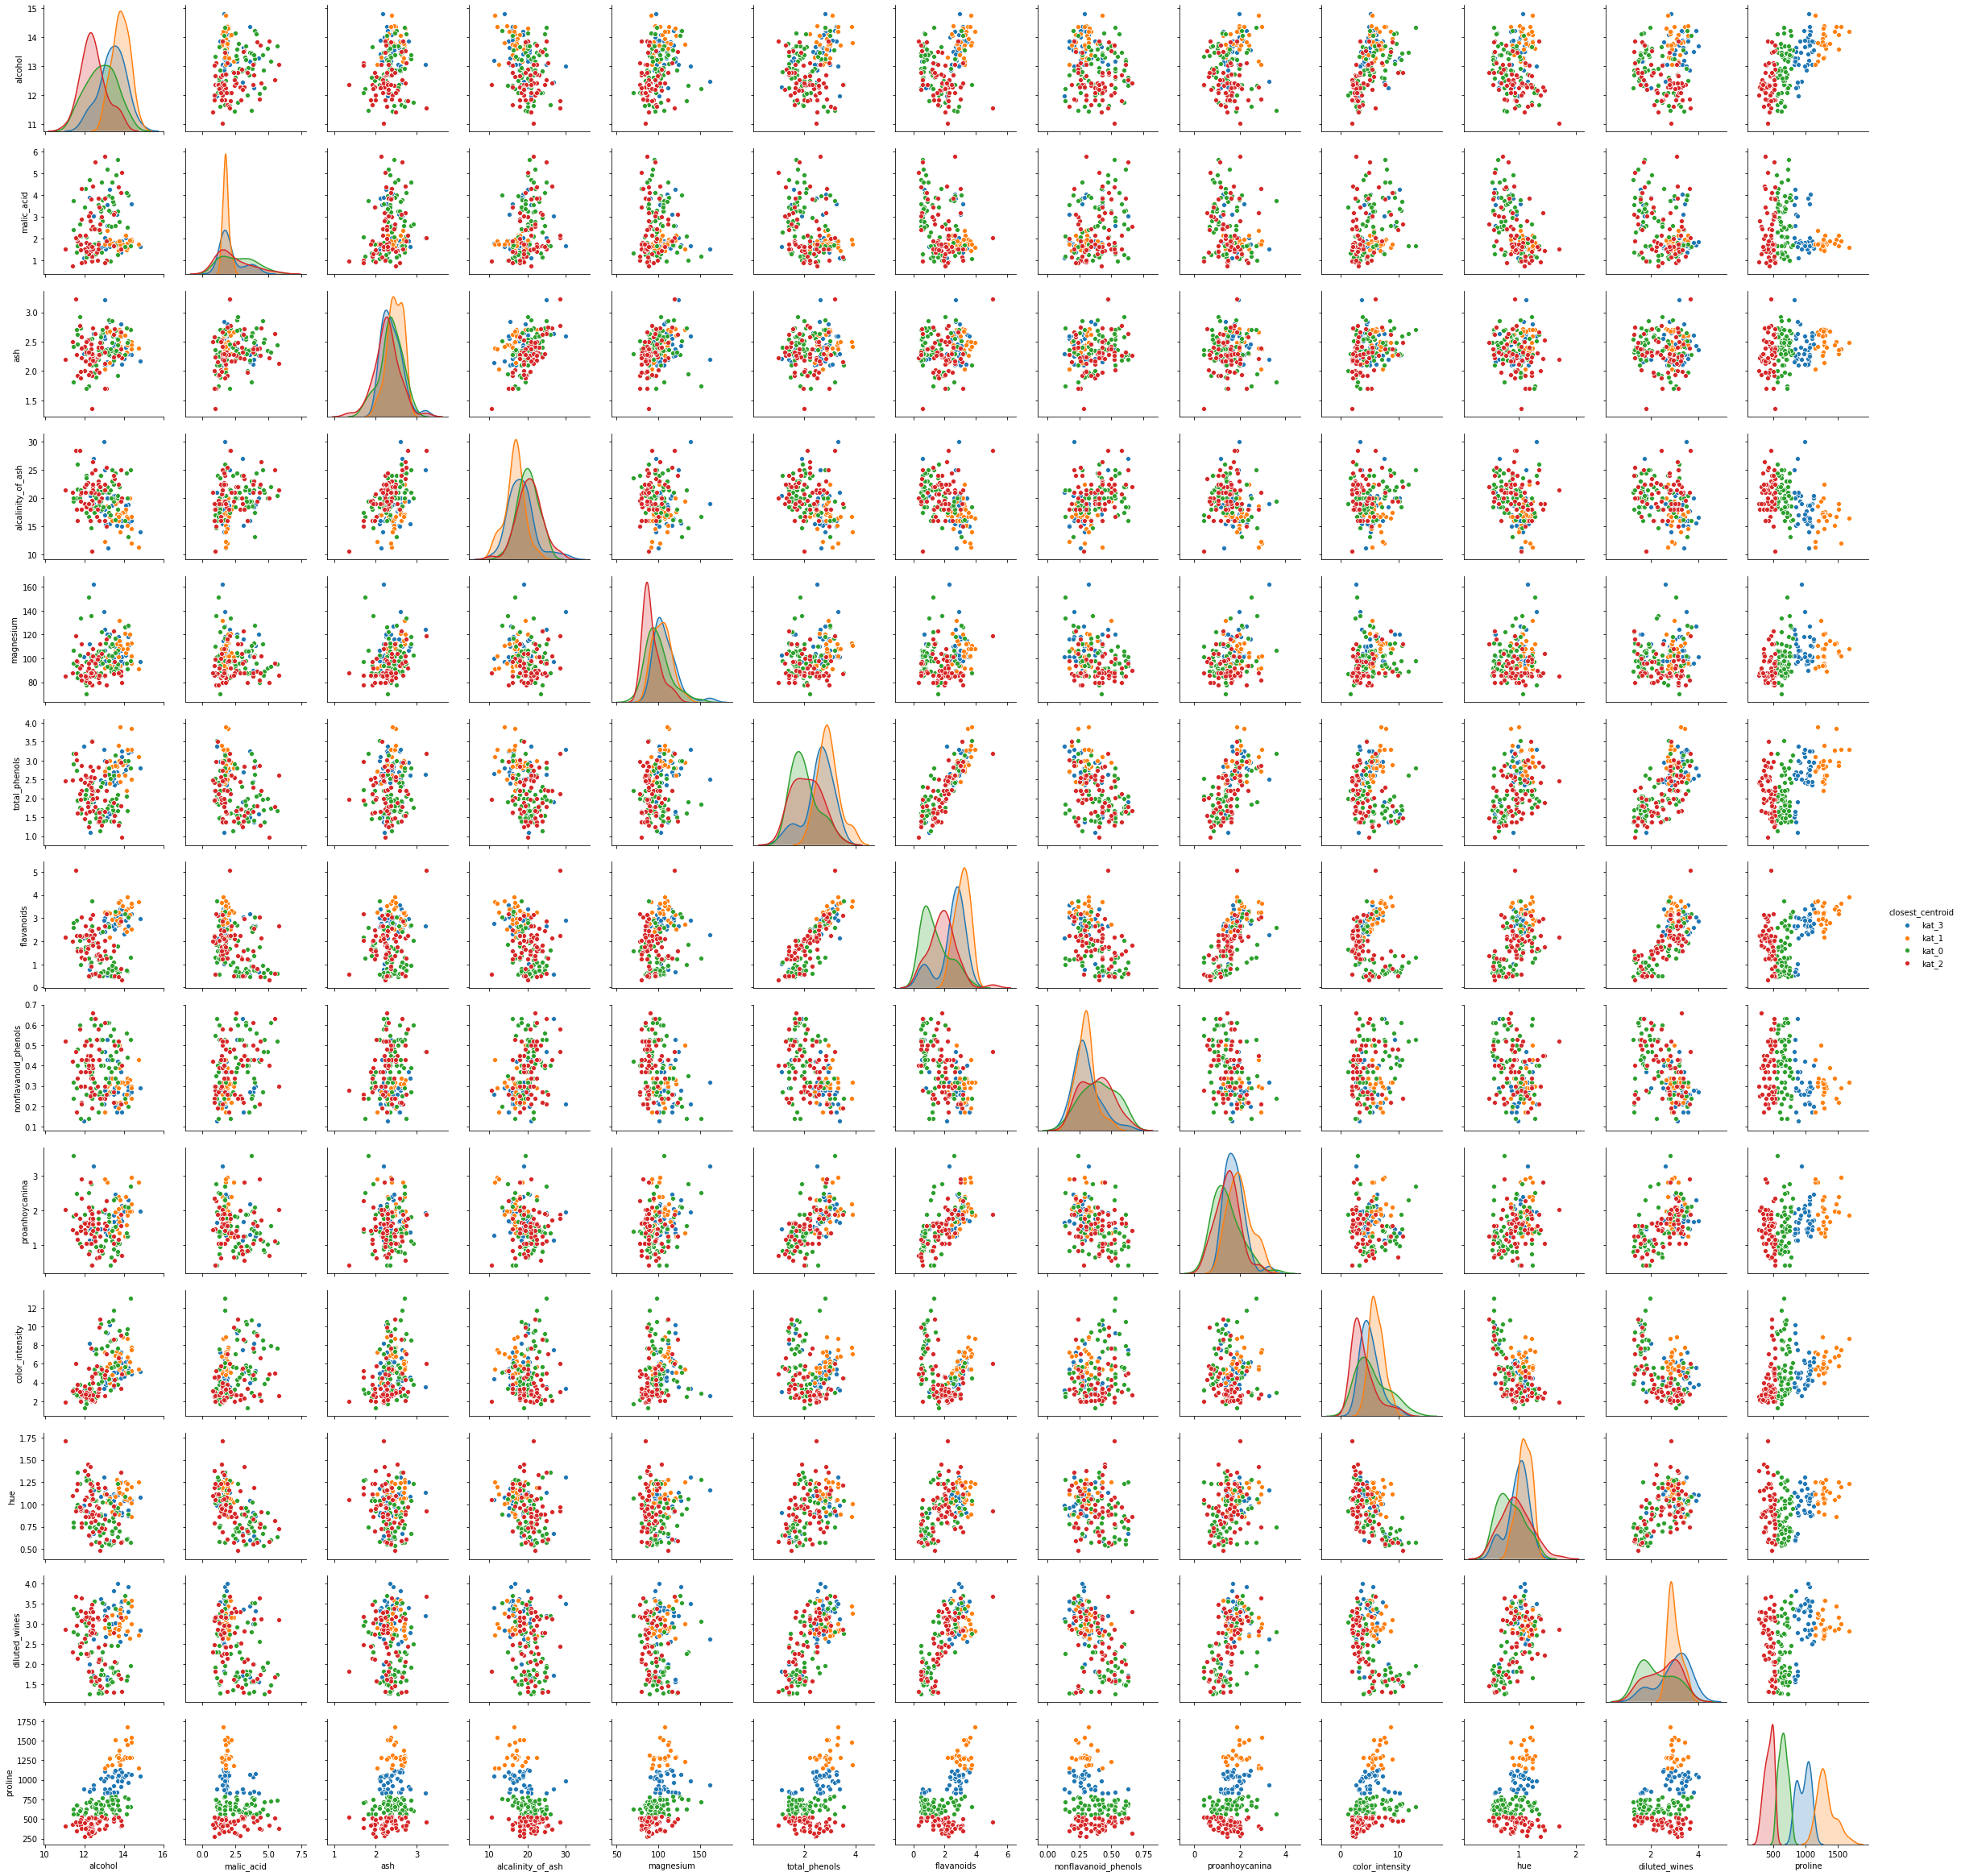

In [82]:

plot_measures(wine_df,10)
data_df = wine_df
data_df['closest_centroid'] = k_means(wine_df.values,4)[1]
data_df['closest_centroid'] = "kat_" + data_df['closest_centroid'].astype(str)
sns.pairplot(data_df, hue = 'closest_centroid')

# Zadanie 4

In [2]:

def plot_image(filepath,filename, K):
    plt.rcParams["figure.figsize"] = (20,10)
    image_3d_array = plt.imread(filepath + "/" + filename)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(image_3d_array)

    
    x = np.shape(image_3d_array)[0]
    y = np.shape(image_3d_array)[1]
    z = np.shape(image_3d_array)[2]
    #print(x,y,z)
    
    image_2d_array = image_3d_array.reshape(x*y,z)
    image_df = pd.DataFrame(data=image_2d_array, index=np.arange(1,x*y+1,1), columns=['r','g','b'])  # 1st row as the column names
    centres, closest_centroid, m = k_means(image_df.values,K)


    ax2.imshow(centres[closest_centroid,:].reshape(x,y,z))




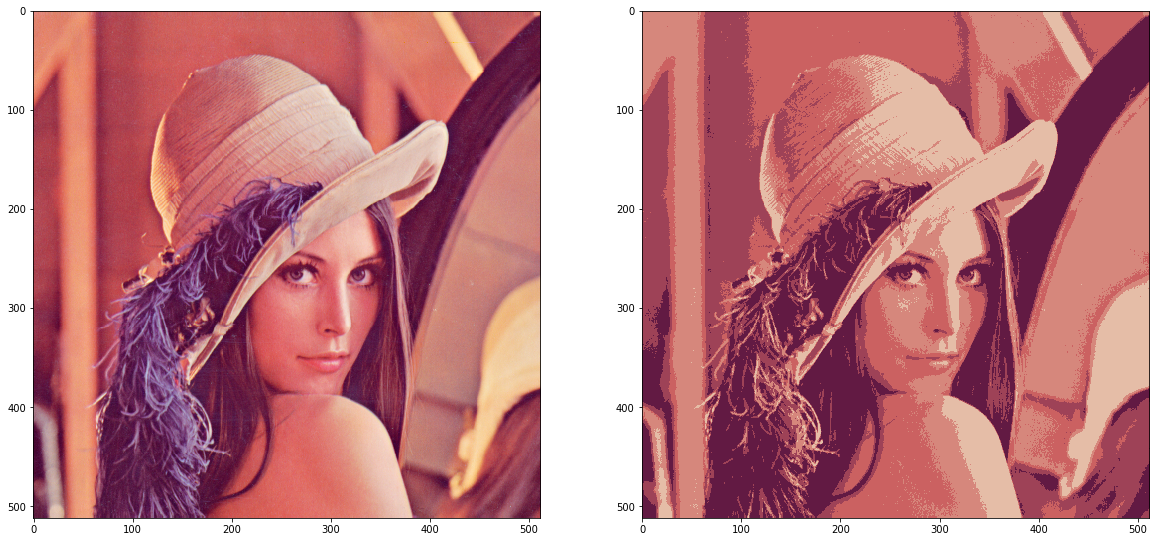

In [1603]:
k=5
plot_image('/home/michal/Dokumenty/Studia/UWr/7/Eksploracja_Danych/lista3/images', 'lena512.png', k)

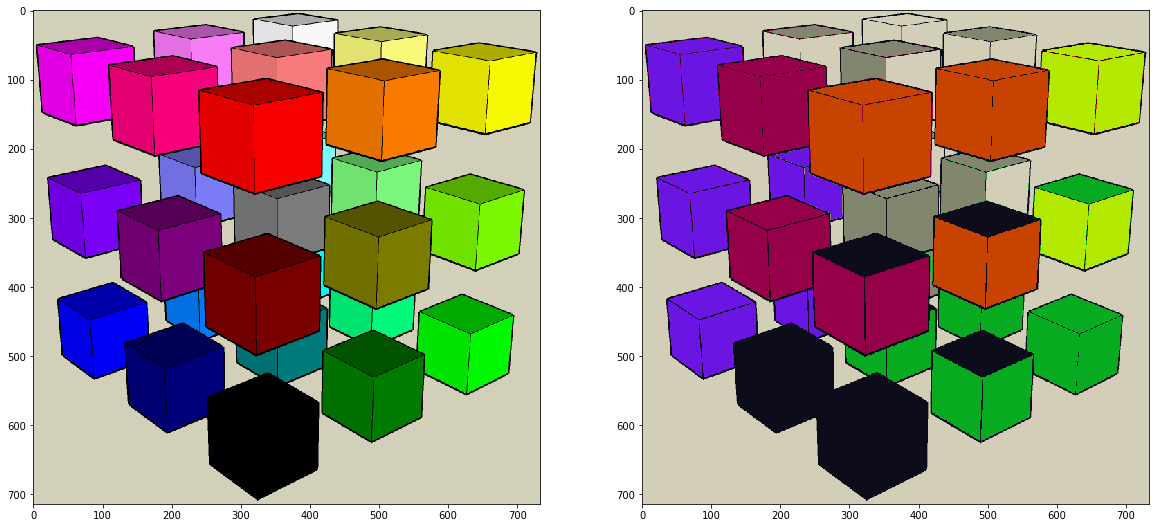

In [6]:
k=10
plot_image('/home/michal/Dokumenty/Studia/UWr/7/Eksploracja_Danych/lista3/images', 'cube.png', k)

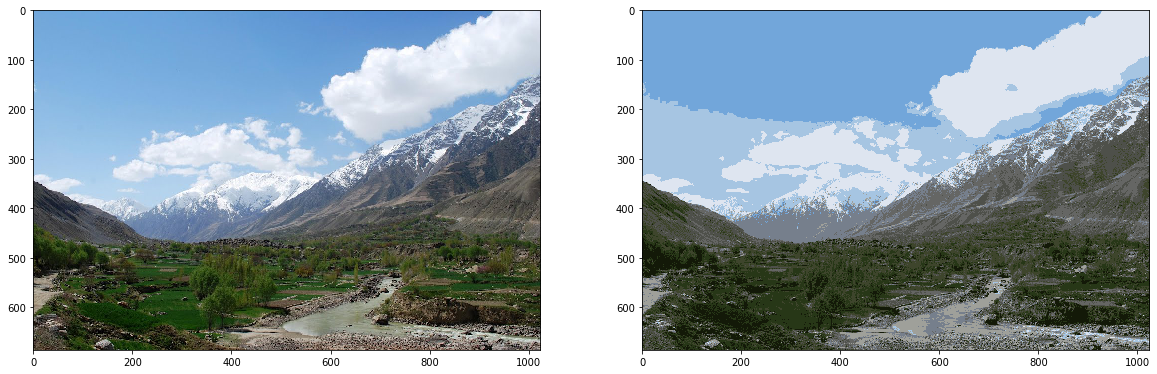

In [7]:
k=10
plot_image('/home/michal/Dokumenty/Studia/UWr/7/Eksploracja_Danych/lista3/images', 'landscape.png', k)

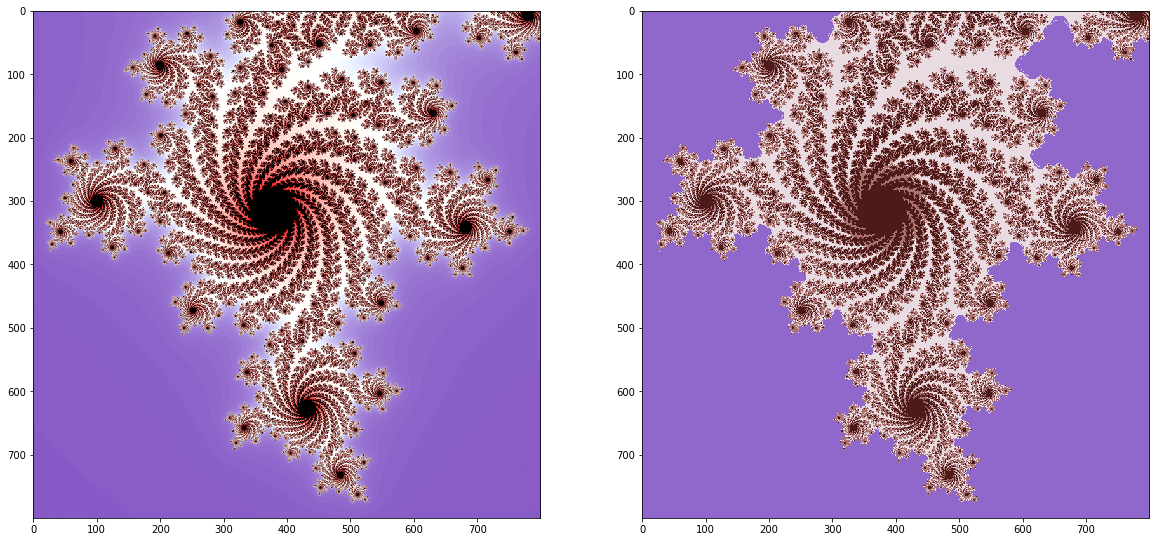

In [12]:
k=4
plot_image('/home/michal/Dokumenty/Studia/UWr/7/Eksploracja_Danych/lista3/images', 'fractal.png', k)

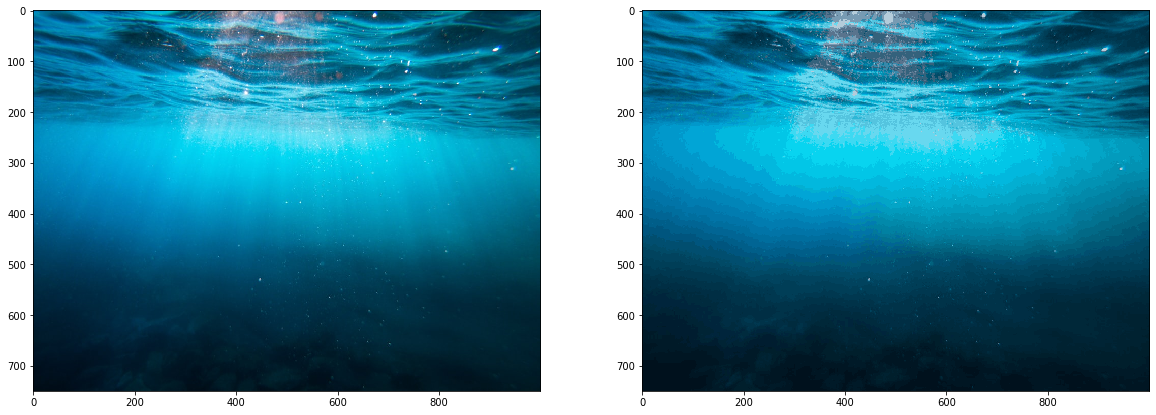

In [16]:
k=50
plot_image('/home/michal/Dokumenty/Studia/UWr/7/Eksploracja_Danych/lista3/images', 'ocean.png', k)